## DASK intro
Original source: https://www.machinelearningplus.com/python/dask-tutorial/

In [1]:
from time import sleep

def apply_discount(x):
    sleep(1)
    x=x-0.2*x
    return x

def get_total(a,b):
    sleep(1)
    return a+b


def get_total_price(x,y):
    sleep(1)
    a=apply_discount(x)
    b=apply_discount(y)
    get_total(a,b)

In [2]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = apply_discount(100)
y = apply_discount(200)
z = get_total_price(x,y)

CPU times: user 2.05 ms, sys: 466 µs, total: 2.52 ms
Wall time: 6.02 s


In [3]:
# Import dask and and dask.delayed
import dask
from dask import delayed

In [4]:
# Wrapping the function calls using dask.delayed
x = delayed(apply_discount)(100)
y = delayed(apply_discount)(200)
z = delayed(get_total_price)(x, y)

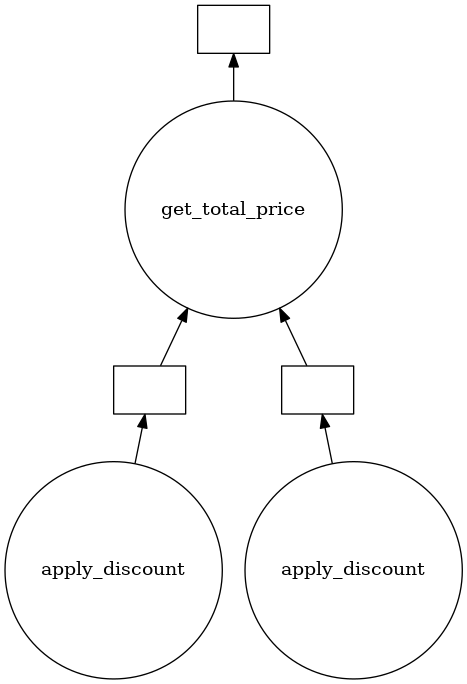

In [5]:
z.visualize()

In [6]:
%%time
z.compute()

CPU times: user 10.3 ms, sys: 13.7 ms, total: 24 ms
Wall time: 5.16 s


### Use decorators

In [7]:
@delayed
def d_apply_discount(x):
    sleep(1)
    x=x-0.2*x
    return x

@delayed
def d_get_total(a,b):
    sleep(1)
    return a+b

@delayed
def d_get_total_price(x,y):
    sleep(1)
    a=apply_discount(x)
    b=apply_discount(y)
    get_total(a,b)

In [8]:
d_x = d_apply_discount(100)
d_y = d_apply_discount(200)
d_z = d_get_total_price(d_x, d_y)

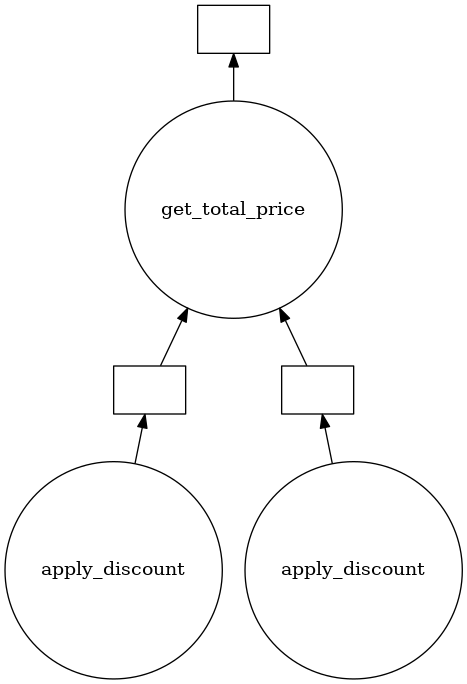

In [9]:
z.visualize()

### Dask DataFrames
A Dask DataFrame is a large parallel DataFrame composed of many smaller Pandas DataFrames, split along the index. 

In [10]:
import dask.dataframe as dd
data_frame = dask.datasets.timeseries()

In [11]:
# Applying groupby operation
df = data_frame.groupby('name').y.std()
df

Dask Series Structure:
npartitions=1
    float64
        ...
Name: y, dtype: float64
Dask Name: sqrt, 67 tasks

In [12]:
data_frame.columns

Index(['id', 'name', 'x', 'y'], dtype='object')

In [13]:
%%time
pandas_df = df.compute()
type(pandas_df)

CPU times: user 2.52 s, sys: 660 ms, total: 3.18 s
Wall time: 5.13 s


pandas.core.series.Series

In [14]:
# Calling the persist function of dask dataframe
df = df.persist()
type(df)

dask.dataframe.core.Series

### Dask Bags
Dask.bag is a high-level Dask collection used as an alternative for the regular python lists, etc. The main difference is Dask Bags are lazy and distributed.

In [ ]:
dask.__version__

In [ ]:
a = db.from_url('http://raw.githubusercontent.com/dask/dask/master/README.rst',) 
a.npartitions  

In [ ]:
import dask.bag as db

### DASK distributed

In [15]:
# Import dask.distributed.Client and pandas
from dask.distributed import Client
import pandas as pd
import time

# Initializing a client
client = Client(processes=False)
client

2021-04-26 10:43:03,063 [1743] WARNING  py.warnings:99: [JupyterRequire] /opt/conda/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40139 instead
  http_address["port"], self.http_server.port



Client Scheduler: inproc://172.20.0.39/1743/1 Dashboard: http://172.20.0.39:40139/status,Cluster Workers: 1 Cores: 16 Memory: 53.69 GB


In [ ]:
client.close()

In [16]:
# Read csv  file into a pandas dataframe and process it
df = pd.read_csv('dask-dist.tsv', sep='\t')
#df = df.drop('Unnamed: 0', axis=1)
#df = df.set_index('itm_nb')
df.head()

,other-empty,2019_Horizon_League_Baseball_Tournament,external,16
0,other-search,ForeverAtLast,external,40
1,other-empty,ForeverAtLast,external,85
2,First_Families_of_Pakistan,Jehangir_Wadia,link,19
3,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36
4,Wadia_family,Jehangir_Wadia,link,715


In [17]:
cols = df.columns

In [18]:
# A function to perform desired operation
def do_operation(df, index, col):
    new_df=df[col]

In [ ]:
%%time
# Loop through the indices and columns and call the function.
for index in df.index:
    for col in cols:
        do_operation(df, index, col)

In [ ]:
%%time
# Use Dask client to parallelize the workload.

# Create a futures array to store the futures returned by Dask
futures = []

# Scatter the dataframe beforehand
df_future = client.scatter(df)

for index in df.index:
    for col in cols:
        # Submit tasks to the dask client in parallel
        future = client.submit(do_operation, df_future, index, col)
        # Store the returned future in futures list
        futures.append(future)

# Gather the results.
_ = client.gather(futures)